#### What should be changed/improved

3) Правильно считай частоту Раби (Надо обобщенную считать)

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from tqdm import tqdm
import copy
from scipy.optimize import curve_fit

#### Definition of constants + technical functions

In [2]:
options = Options()
options.nsteps = 10000

# DC magnetic fields
bx=0 #in Tesla
by=0 #in Tesla
bz=0.05 #in Tesla


MW_Rabi = 10e0 # 1MHz
RF_Rabi = 3e-3 # 3kHz

T2El = 1e3 # us 
T1El = 1e6 # us 

# T1N=infinity
# T2N=infinity
D_gs  = 2.87e3 #2.87 GHz
g_el  = 28.8e3 # electron gyromagnetic ratio
g_nuc = 10.71 # nuclear gyromagnetic ratio
A_pargs= 6.28*33e-3
A_ortgs= 6.28*35e-3


wMW = (D_gs+bz*(g_el+g_nuc)+A_pargs)
# !!!!!!!!!!!!!!!!!!!!
# A_pargs=A_ortgs=bx=by=0
# bx=by=0
# !!!!!!!!!!!!!!!!!!!!

In [3]:
# Some technical functions
Sx = tensor(jmat(1,'x'),identity(2))
Sy = tensor(jmat(1,'y'),identity(2))
Sz = tensor(jmat(1,'z'),identity(2))
Ix = (tensor(qeye(3),sigmax()))
Iy = (tensor(qeye(3),sigmay())) 
Iz = (tensor(qeye(3),sigmaz()))

#### Hamiltonian of ground state

In [4]:
#Hamiltonian

H0 = (D_gs-wMW)*Sz*Sz # D_gs * Sz^2
Hhf = A_pargs  * Sz*Iz+A_ortgs  * Sz*Ix  # Hyperfine coupling A_parallel* Sz *Iz  + A_ort *Sz Ix
Hzel =  bx*g_el*Sx + by*g_el*Sy + bz*g_el*Sz # electronic spin in magnetic field
Hznuc = bx*g_nuc*Ix + by*g_nuc*Iy + bz*g_nuc*Iz # nuclear spin in magnetic field

H  = H0+Hzel+Hhf+Hznuc # Total Hamiltonian

# collapse operators:
c_ops = [  
    1/T1El*tensor(basis(3,1)*basis(3,0).dag(),qeye(2)), # T1 Electron spin
    1/T2El*tensor(jmat(1,'z'),qeye(2))] # T2 Electron spin

e_ops=[] 
allStates=[] # array of all intermidiate states 
allTimes=[] # array of times

#### Energy levels plot

electron zeeman  1440.0 Mhz
parallel hyperfine coupling  0.207 Mhz
ortogonal hyperfine coupling  0.22 Mhz
nuclear zeeman  0.536 Mhz
nuclear spinflip rate  0.08060634625088892


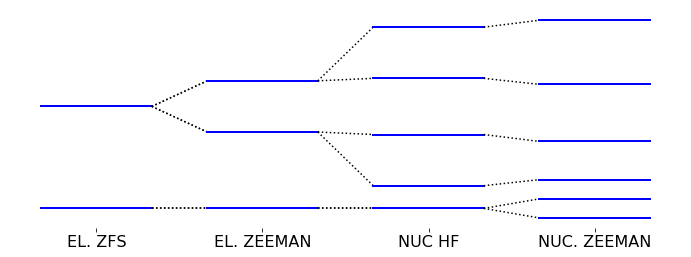

In [5]:
%matplotlib inline
print('electron zeeman ' , np.round(bz*g_el, 3), 'Mhz')
print('parallel hyperfine coupling ' , np.round(A_pargs,3), 'Mhz' )
print('ortogonal hyperfine coupling ' , np.round(A_ortgs,3), 'Mhz' )
print('nuclear zeeman ' , np.round(bz*g_nuc,3) , 'Mhz')
print('nuclear spinflip rate ' , 
      np.round(A_ortgs,3)**2 / 
      (np.round(A_ortgs,3)**2 + (np.round(bz*g_nuc+A_pargs,3)**2 ))
     )


# plot_energy_levels([H0,Hzel,Hhf,Hznuc],figsize=(12,4),labels = ['EL. ZFS','EL. ZEEMAN','NUC HF','NUC. ZEEMAN']);

#with random scale coefficients
plot_energy_levels([(H0+wMW*Sz*Sz)/5,Hzel/10,Hhf*1000,Hznuc*100],figsize=(12,4),labels = ['EL. ZFS','EL. ZEEMAN','NUC HF','NUC. ZEEMAN']);


#### Pulses

In [6]:
# def optical_exc(state):
        
#     global allStates
#     global total_time
#     global allTimes

#     tlist = np.linspace(total_time,total_time+time,2000)
#     total_time+=time    
    
#     output = mesolve(H, state, tlist, c_ops, e_ops)  
#     allStates=allStates + output.states
    
#     allTimes =allTimes  + list(tlist)
    
#     return output   

In [7]:
def free_evol(state,time):    
    '''
    operator of free evolution 
    state = initial state of the system, time = duration of free evolution
    '''
    
    global allStates
    global total_time
    global allTimes

    tlist = np.linspace(total_time,total_time+time,2000)
    total_time+=time    
    
    output = mesolve(H, state, tlist, c_ops, e_ops)  
    allStates=allStates + output.states
    
    allTimes =allTimes  + list(tlist)
    
    return output   

In [8]:

def init(state,time):
    
    '''
    non-unitary operation of electron spin initialization to |0> state.
    state = initial state of the system, time = duration of initialization pulse
    '''
    global allStates
    global total_time
    global allTimes
    
    temp=[total_time]
#     temp.append()
    tlist = np.linspace(total_time,total_time+time,2000)
    total_time+=time    
    temp.append(total_time)
    
    init_times.append(temp)
    c=c_ops.copy()
    c.append(15*tensor(basis(3,1)*basis(3,0).dag(),qeye(2)))
    c.append(15*tensor(basis(3,1)*basis(3,2).dag(),qeye(2)))
             
    output = mesolve(H, state, tlist, c, e_ops, options=options)  
    allStates=allStates + output.states
    allTimes =allTimes  + list(tlist)
    
    return output    

In [9]:
#!!! Doesn't count phase
def MW_exc(state,time,w):
    
     
    '''
    operator of microwave excitation in interaction picture
    state = initial state of the system, time = duration of MW, w = MW frequency
    '''
    global allStates
    global total_time
    global allTimes

#     delta = D_gs+bz*g_el - w #detuning from 0,-1/2 --> 1,-1/2 transition
#     MW_Rabi_general = np.sqrt(MW_Rabi**2+delta**2) #

    MW_Rabi_general = MW_Rabi
    if time=='pi':
        time= np.pi/MW_Rabi_general *np.sqrt(2)
    if time=='pi/2':
        time= 0.5 * np.pi/MW_Rabi_general *np.sqrt(2)

    temp=[total_time]        
    tlist = np.linspace(total_time,total_time+time,2000)   
    total_time+=time        
    temp.append(total_time)
    MW_times.append(temp)

    
    
    H_MW_exc=H.copy()   
    H_MW_exc += MW_Rabi_general/2 *Sx
    
#     H_MW_exc += - D_gs*Sz*Sz - (w-D_gs)*Sz +MW_Rabi_general/2 *Sx #
# 
    output = mesolve(H_MW_exc, state, tlist, c_ops, e_ops, options=options )    
    
    allStates = allStates + output.states
    allTimes =allTimes  + list(tlist)
    
    return output

In [10]:
def RF_exc(state,time,wRF):
    '''
    operator of radiofrequency excitation, NOT in interaction picture
    state = initial state of the system, time = duration of RF, wRF = RF frequency
    '''
    
    global allStates
    global total_time
    global allTimes
    
    
    
    if time=='pi':
        time=np.pi/RF_Rabi

    if time=='pi/2':
        time= 0.5*np.pi/RF_Rabi
    tlist = np.linspace(total_time,total_time+time,2000)
    
    H_RF_exc = [H, [RF_Rabi*Ix,'cos(wRF * t)'] ]

    args = {'wRF': wRF}
    total_time+=time    

    output = mesolve(H_RF_exc, state, tlist, c_ops, e_ops, options=options, args=args )    

    allStates=allStates + output.states
    allTimes =allTimes  + list(tlist)
    
    return output

#### Pulse sequence 


In [11]:
s1=tensor(basis(3,1),basis(2,0)).unit() # MW(espin) = 0 basis(3,1), RF(nspin) = -1/2 basis(2,1)

allStates=[s1*s1.dag()]
allTimes=[0]
total_time=0

MW_times=[]
RF_times=[]
free_evol_times=[]
init_times=[]

MW_exc(allStates[-1],'pi',wMW) 

espin = expect(allStates, tensor(jmat(1,'z'),qeye(2)))
nspin = expect(allStates, tensor(qeye(3),sigmaz()))

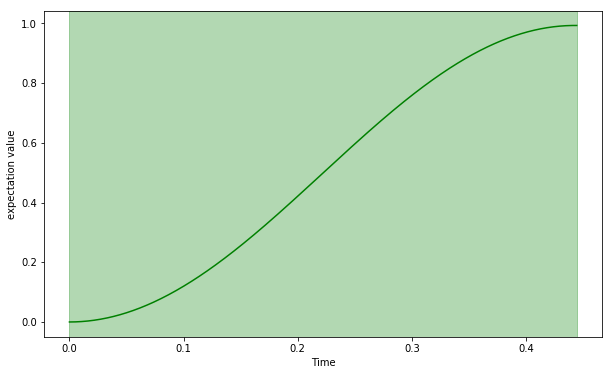

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(allTimes, espin, 'g')
# ax.plot(allTimes, nspin, 'b')

for t in RF_times:
    ax.axvspan(t[0], t[1], alpha=0.1, color='blue')
for t in free_evol_times:
    ax.axvspan(t[0], t[1], alpha=0.1, color='grey')
for t in init_times:
    ax.axvspan(t[0], t[1], alpha=0.1, color='red')
for t in MW_times:
    ax.axvspan(t[0], t[1], alpha=0.3, color='green')
    
ax.set_xlabel('Time')
ax.set_ylabel('expectation value');
plt.show()

#### Old Ideas

#####  Добавь метастабильный уровень и декогеренцию в верхнем состоянии

На самом деле не надо, так как вся эта симуляция для того, чтбы следить за спином 13С, а ему пофиг на такие быстрые флуктуации фазы электронного спина



#### Tests